In [4]:
import torch
from torch import nn
import matplotlib.pyplot as plt


In [6]:
class UniNN(nn.Module):
    def __init__(self, hidden):
        super(UniNN, self).__init__()
        self.device = "cpu"
        #if hidden > 500:
        #    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.hidden = hidden       
        self.fc1 = nn.Linear(1, self.hidden)           
        self.activation = nn.ReLU()                     
        self.fc2 = nn.Linear(self.hidden, 1)
        self.test_loss_reached = False
        self.end_test_loss = 0         

    def forward(self, x):
        out_1 = self.activation(self.fc1(x.to(self.device)))
        return self.fc2(out_1)

    def get_dataloader(self,f,num_samples=10000, batch_size = 32):
        X = torch.vstack((torch.rand(num_samples, 1), torch.zeros(num_samples //20 ,1)))
        train_dataset = torch.utils.data.TensorDataset(X, f(X))
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        return train_dataloader

    def fit(self, dataloader, dataloader_test, epochs=100, lr=0.001, decay = 1e-3, B = 10):
        self.to(self.device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.RAdam(self.parameters(), lr=lr, weight_decay=0)
        train_losses = []
        test_losses = []
        iters = 0
        epoch = 0
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
        while True:
            epoch += 1
            self.train()
            running_train_loss = 0.0
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                reg_loss = self.reg()
                overall_loss = loss + decay * reg_loss
                optimizer.zero_grad()
                overall_loss.backward()
                optimizer.step()
                running_train_loss += loss.item()
                #self.project(B)
            avg_train_loss = running_train_loss / len(dataloader)
            train_losses.append(avg_train_loss)
            self.eval() 
            running_test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in dataloader_test:
                    outputs = self(inputs.to(self.device))
                    loss = criterion(outputs, labels.to(self.device))
                    running_test_loss += loss.item()
            avg_test_loss = running_test_loss / len(dataloader_test)
            test_losses.append(avg_test_loss)
            if avg_test_loss < 5e-3:
                iters += 1
            else:
                iters = 0
            if iters == 10:
                self.test_loss_reached = True
                
            #print(f""" Epoch:{epoch}, trainloss:{avg_train_loss}, testloss:{avg_test_loss}, lr = {optimizer.param_groups[0]["lr"]}""")
            scheduler.step()
            #if optimizer.param_groups[0]["lr"] < 2e-5:
            #    self.test_loss_reached = False
            #    break
            if epoch > 500:
                break
        self.end_test_loss = sum(test_losses[-5:]) / 5 
        self.compute_lipschitz_constant()
        self.model_err_sup_norm()
        print(self.hidden, decay,self.L, self.test_loss_reached, test_losses[-5:])
        return test_losses
    
    def plot_model(self, f, title):
        x_train = torch.linspace(0,1,1000)
        with torch.no_grad():
            y_pred = self(x_train.view(-1,1))
        print("estimated_sup_norm_error", torch.max(torch.abs(y_pred.view(-1) - f(x_train))))
        plt.plot(x_train.numpy(), y_pred.numpy(), label="Model")
        plt.plot(x_train.numpy(), f(x_train).numpy(), label="Objective")
        plt.title("Model Predictions vs Data" + ' decay:' + title)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

    def reg(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss += torch.linalg.matrix_norm(param, ord = float('inf'))
        return reg_loss

    def model_err_sup_norm(self):
        x_train = torch.linspace(0,1,1000)
        with torch.no_grad():
            y_pred = self(x_train.view(-1,1)).to("cpu")
        self.sup_err = torch.max(torch.abs(y_pred.view(-1) - f(x_train)))

    def compute_lipschitz_constant(self):
        self.L = 1
        for name, param in self.named_parameters():
            if 'weight' in name:
                #self.L *= torch.linalg.matrix_norm(param, ord = 1)
                self.L *= torch.linalg.matrix_norm(param, ord = float('inf'))
        

In [7]:
def f(X):
    return X**0.23
    #return torch.sin(X)

In [8]:
def small_norm_init(m, scale=0.01):
    """Custom initialization with small norm for weights."""
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, -scale, scale)  # Uniformly small weights

In [9]:
model = UniNN(16)
dataloader_train = model.get_dataloader(f)
dataloader_test = model.get_dataloader(f, num_samples=200)
models = {}
L = []
decays = [0,0.1,1e-2,1e-3] 
#decays = [1e-2]
for i in range(3,16):
    diction = {2**i: []}
    for decay in decays:
        model = UniNN(2**i)
        model.apply(lambda m: small_norm_init(m, scale=0.01))
        loss = model.fit(lr = 1e-3, dataloader=dataloader_train, dataloader_test=dataloader_test, decay=decay)
        diction[2**i].append(model)
    models.update(diction)


8 0 tensor(0.7775, grad_fn=<MulBackward0>) False [0.01459642652688282, 0.016232499719730446, 0.015344795903989248, 0.015474433145884956, 0.014581478200852871]
8 0.1 tensor(5.2614e-07, grad_fn=<MulBackward0>) False [0.05173849420888083, 0.05150636777813945, 0.05358710592346532, 0.054053209988134246, 0.05261966107147081]
8 0.01 tensor(0.5735, grad_fn=<MulBackward0>) False [0.016184385932449783, 0.015219911001622677, 0.016364978992247155, 0.016972368017637303, 0.01604887447319925]
8 0.001 tensor(0.6221, grad_fn=<MulBackward0>) False [0.01546862774661609, 0.014581464497106416, 0.01533613633364439, 0.014450403096686517, 0.014779221599123307]
16 0 tensor(0.8117, grad_fn=<MulBackward0>) False [0.014673789996387703, 0.014658340119889804, 0.014556728835616792, 0.01461219132345702, 0.015421271324157715]
16 0.1 tensor(8.7519e-07, grad_fn=<MulBackward0>) False [0.05477513772036348, 0.05273810827306339, 0.051992038264870644, 0.05151477163391454, 0.05276834326131003]


KeyboardInterrupt: 

In [726]:
import dill
with open("models_sin.dill", "wb") as file:
    dill.dump(models, file)

In [724]:
module = models[2**3][0]
L = 1
for name, param in module.named_parameters():
    if 'weight' in name:
        order = 2
        print(param)
        print(torch.linalg.matrix_norm(param, ord = 1))
        print(torch.linalg.vector_norm(param.flatten(), ord = 2))
        #L *= (torch.linalg.vector_norm(param.flatten(), ord = order) + 1.19e-7 * 2** 15) * order
        L *= torch.linalg.vector_norm(param.flatten(), ord = order)

Parameter containing:
tensor([[ 4.2506e-01],
        [ 6.7726e-01],
        [ 6.5290e-01],
        [ 6.8716e-01],
        [-1.9799e-03],
        [ 6.8322e-03],
        [-1.7016e-01],
        [-6.5252e-04]], requires_grad=True)
tensor(2.6220, grad_fn=<AmaxBackward0>)
tensor(1.2517, grad_fn=<LinalgVectorNormBackward0>)
Parameter containing:
tensor([[ 3.2492e-02,  3.8880e-01,  2.7945e-01,  5.5286e-01, -6.0086e-03,
         -4.9613e-05, -1.4649e-01, -2.3503e-03]], requires_grad=True)
tensor(0.5529, grad_fn=<AmaxBackward0>)
tensor(0.7466, grad_fn=<LinalgVectorNormBackward0>)


In [725]:
print(L)
x = 0.0
y = 0.000000016
#print(torch.abs(module(torch.tensor([[0]], dtype = torch.float32))).item())
print(torch.abs(module(torch.tensor([[x]], dtype = torch.float32)) - module(torch.tensor([[y]], dtype = torch.float32))).item())
print(L.item()*abs(x - y))

tensor(0.9346, grad_fn=<MulBackward0>)
1.4901161193847656e-08
1.495352649688721e-08


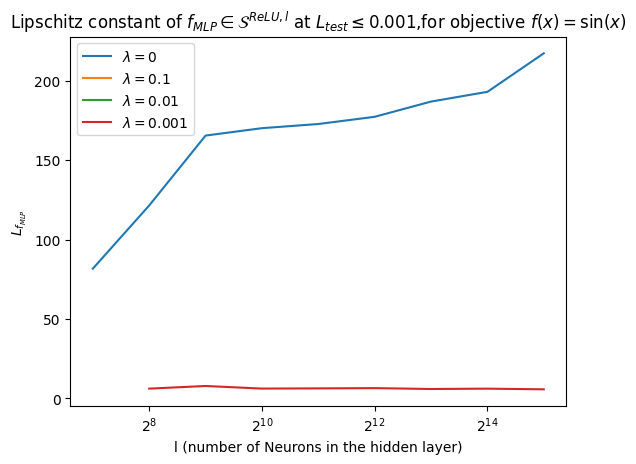

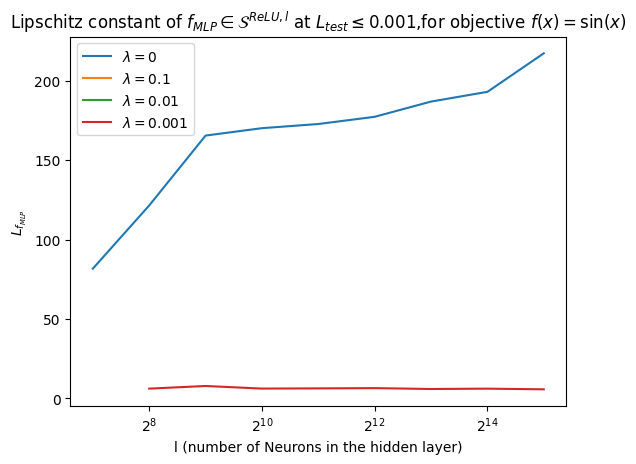

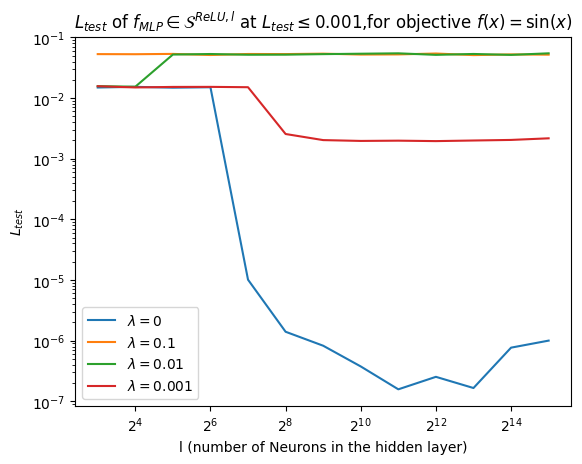

In [763]:
for j,decay in enumerate(decays):
    Lips = []
    Neurons = []
    #if (j == 0) or (j == 1) or (j == 2):
    #    continue
    for i in range(3,16):
        if models[2**i][j].test_loss_reached:
            Lips.append(models[2**i][j].L.item())
            Neurons.append(2**i)
    plt.plot(Neurons,Lips, label = r"$\lambda = $" + f"{decay}")
plt.xscale('log', base=2)
plt.xlabel("l (number of Neurons in the hidden layer)")
plt.ylabel(r"$L_{f_{MLP}}$")
plt.title(r"Lipschitz constant of $f_{MLP} \in \mathcal{S}^{ReLU, l}$ at $L_{test} \leq 0.001$,for objective $f(x) = x^{0.23}$")
plt.legend()
plt.show()

for j,decay in enumerate(decays):
    Lips = []
    Neurons = []
    #if (j == 3) or (j == 1) or (j == 2):
    #    continue
    for i in range(3,16):
        if models[2**i][j].test_loss_reached:
            Lips.append(models[2**i][j].L.item())
            Neurons.append(2**i)
    plt.plot(Neurons,Lips, label = r"$\lambda = $" + f"{decay}")
plt.xscale('log', base=2)
plt.xlabel("l (number of Neurons in the hidden layer)")
plt.ylabel(r"$L_{f_{MLP}}$")
plt.title(r"Lipschitz constant of $f_{MLP} \in \mathcal{S}^{ReLU, l}$ at $L_{test} \leq 0.001$,for objective $f(x) = x^{0.23}$")
plt.legend()
plt.show()

for j,decay in enumerate(decays):
    #if (j == 1) or (j == 2):
    #    continue
    Lips = []
    Neurons = []
    for i in range(3,16):
        Lips.append(models[2**i][j].end_test_loss)
        Neurons.append(2**i)
    plt.plot(Neurons,Lips, label = r"$\lambda = $" + f"{decay}")
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.xlabel("l (number of Neurons in the hidden layer)")
plt.ylabel(r"$L_{test}$")
plt.title(r"$L_{test}$ of $f_{MLP} \in \mathcal{S}^{ReLU, l}$ at $L_{test} \leq 0.001$,for objective $f(x) = \sin(x)$")
plt.legend()
plt.show()

estimated_sup_norm_error tensor(0.5562)


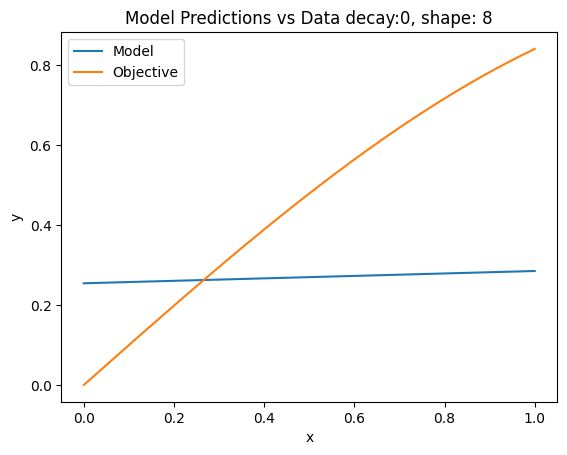

tensor(0.0421, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.5198)


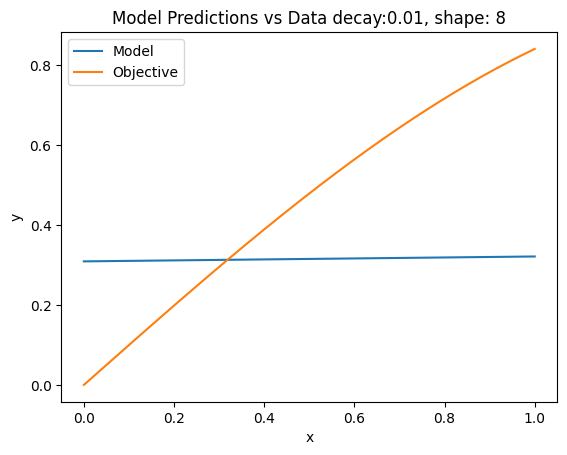

tensor(0.0125, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4118)


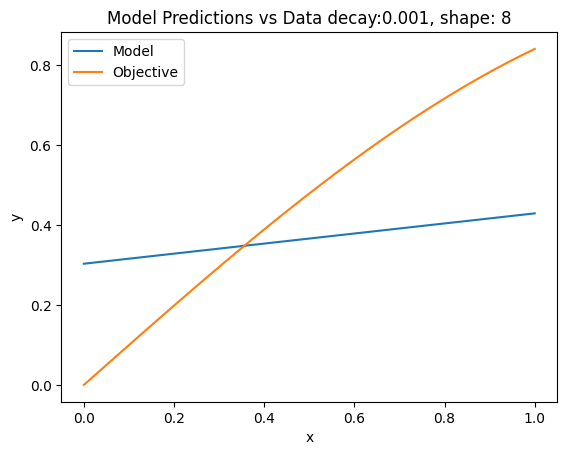

tensor(0.1398, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.5491)


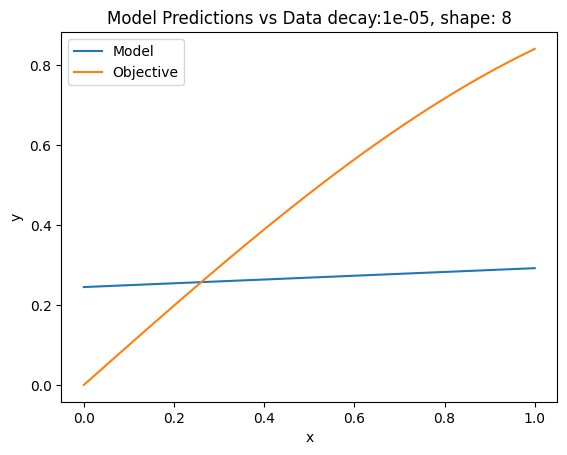

tensor(0.0567, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4270)


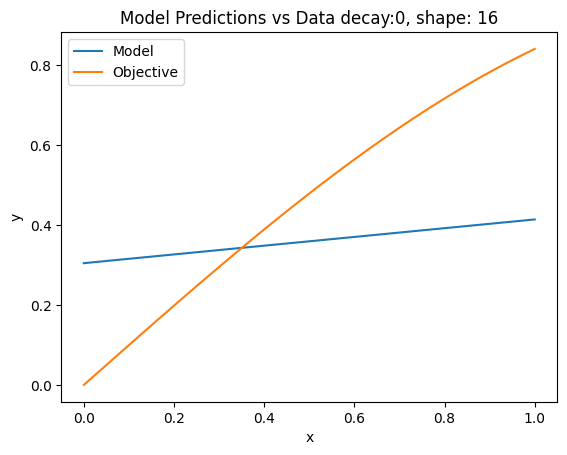

tensor(0.1389, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4348)


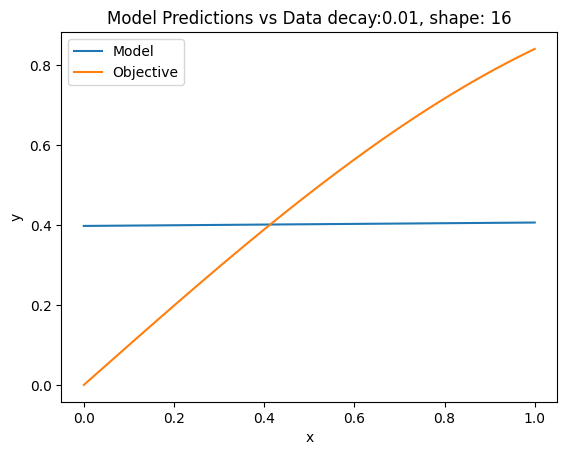

tensor(0.0105, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4894)


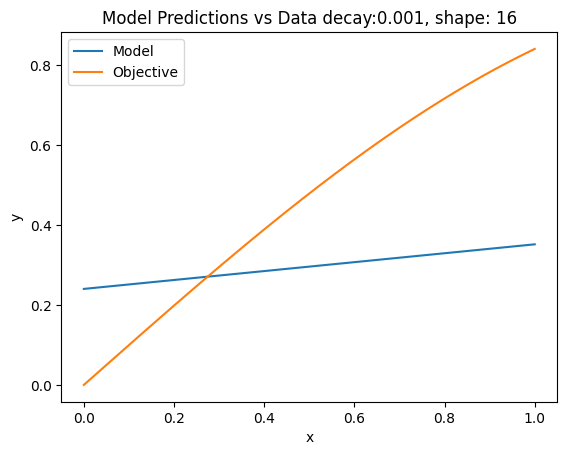

tensor(0.1386, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4361)


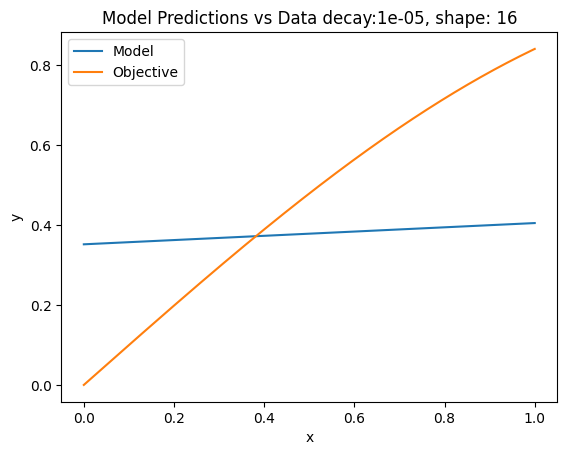

tensor(0.0685, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4244)


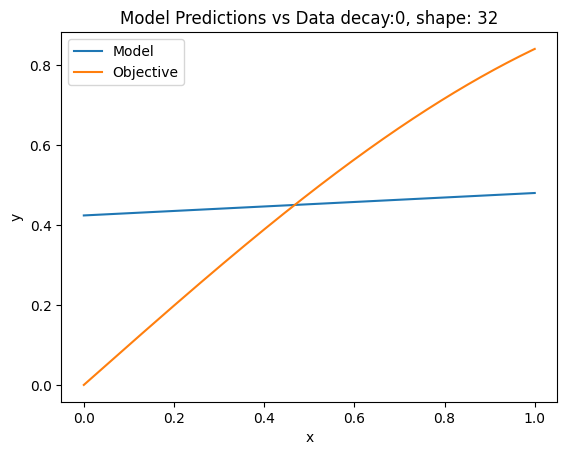

tensor(0.0899, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4506)


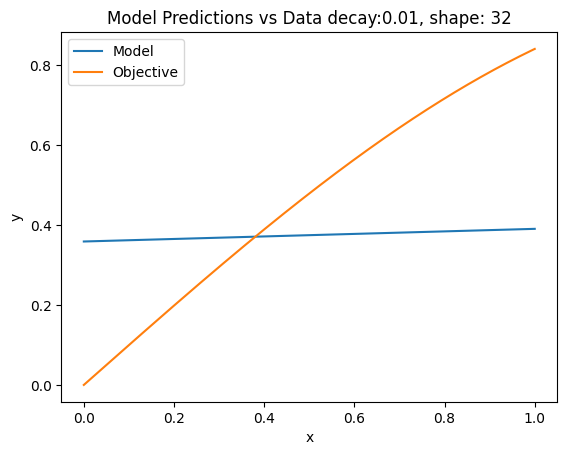

tensor(0.0347, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4206)


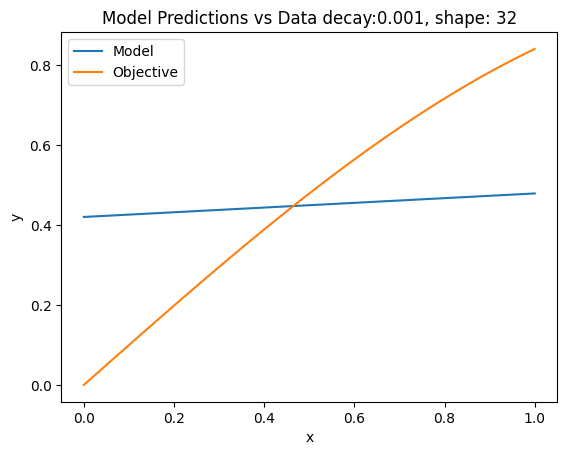

tensor(0.0769, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4238)


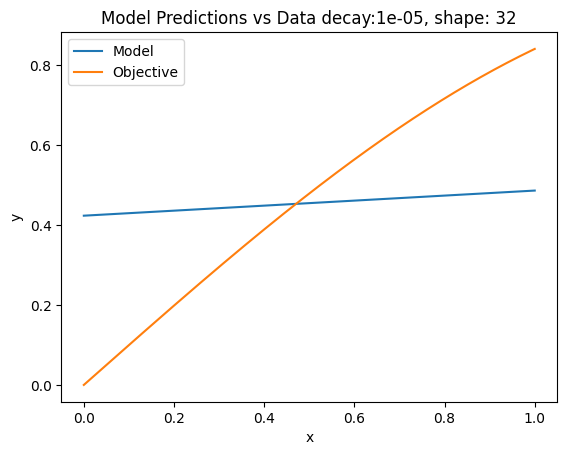

tensor(0.1491, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4163)


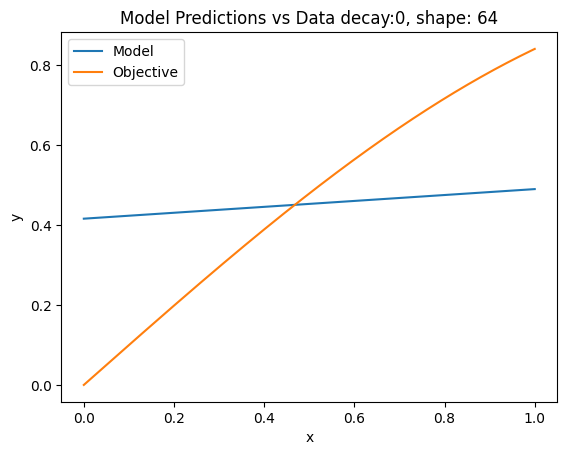

tensor(0.1259, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4384)


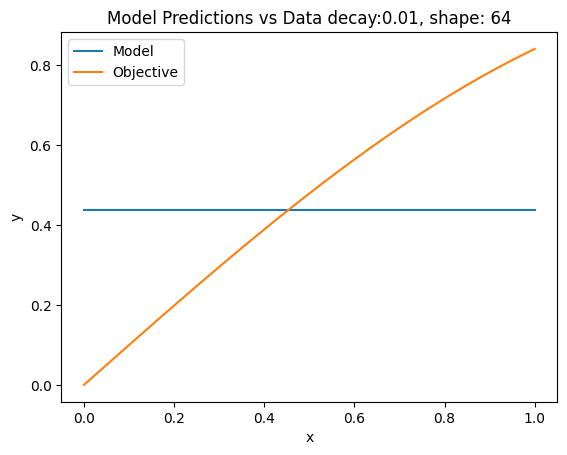

tensor(0.0001, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4203)


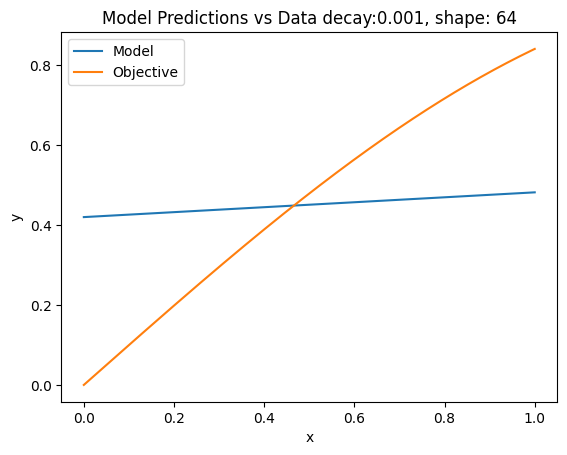

tensor(0.1273, grad_fn=<MulBackward0>)
estimated_sup_norm_error tensor(0.4159)


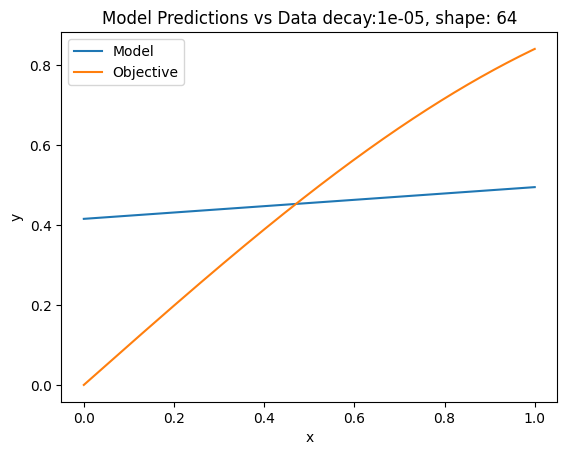

tensor(0.1794, grad_fn=<MulBackward0>)


In [471]:
for i in range(3,7):
    for j,decay in enumerate(decays):
        models[2**i][j].plot_model(f, f"{decay}, shape: {2**i}")
        print(models[2**i][j].L)
        

estimated_sup_norm_error tensor(0.5980)


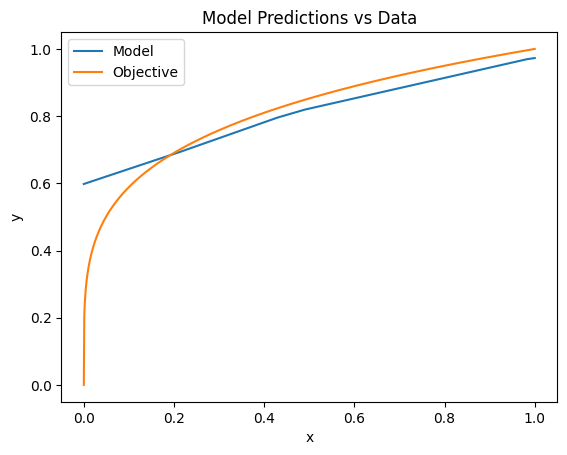

In [247]:
model.plot_model(f)

In [143]:
L = model.L

In [157]:
x = 0.0
y = 0.00000002
print(torch.abs(model(torch.tensor([[0]], dtype = torch.float32))).item())
print(torch.abs(model(torch.tensor([[x]], dtype = torch.float32)) - model(torch.tensor([[y]], dtype = torch.float32))).item())
print(L.item()*abs(x - y))

0.3193759322166443
1.1920928955078125e-07
1.4855443954467773e-07


In [105]:
torch.abs(model(torch.tensor([[x]], dtype = torch.float32)) - model(torch.tensor([[y]], dtype = torch.float32))).item() <= L.item()*abs(x - y)

True